# Comparison of various Classification algorithms

In [1]:
# Accelerate SVC a bit
from sklearnex import patch_sklearn
patch_sklearn()
import shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, f1_score, roc_auc_score
)
from xgboost import plot_importance
import seaborn as sb
from matplotlib.ticker import FormatStrFormatter

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Custom functions to evaluate models

In [2]:
# Define all the funcs to later evaluate models
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.matshow(cm, cmap="coolwarm", alpha=0.7)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(x=j, y=i, s=cm[i, j], ha='center', va='center')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


def plot_precision_recall(y_true, y_probs, model_name="Model"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1 = f1_score(y_true, (y_probs >= 0.5).astype(int))
    plt.figure()
    plt.plot(recall, precision,
             label=f"Precision-Recall Curve (F1 = {f1:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.show()


def plot_roc_curve(y_true, y_probs, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.show()

    df = pd.DataFrame({"Model": [model_name], "ROC AUC": [roc_auc]})

    latex_table = df.to_latex(
        index=False,
        caption=f"ROC AUC for {model_name}",
        label=f"tab:roc_auc_{model_name.lower().replace(' ', '_')}",
        column_format="lc"
    )

    print(latex_table)


# Malicious
dfm = pd.read_csv("mal.csv")
# Benign
dfb = pd.read_csv("benign1.csv")

df = pd.concat([dfm, dfb], ignore_index=True)


## Dataframe preparation


In [3]:
df['EC Level'] = df['Error Correction Level'].map(
    {'L': 1, 'M': 2, 'Q': 3, 'H': 4}).astype(int)

df.to_csv("test.csv", sep='\t')
df.head(10)

,Version,Error Correction Level,Number of Blocks,Expected number of data codewords,Actual number of data codewords,Number of empty bytes,Number of EC Codewords,Errors corrected,Modified,EC Level
0,3,H,2,26,19,7,22,0,1,4
1,2,Q,1,22,20,2,22,0,1,3
2,1,L,1,19,19,0,7,0,1,1
3,2,Q,1,22,20,2,22,0,1,3
4,2,H,1,16,15,1,28,0,1,4
5,1,L,1,19,18,1,7,0,1,1
6,3,M,1,44,43,1,26,0,1,2
7,1,M,1,16,14,2,10,0,1,2
8,2,M,1,28,27,1,16,0,1,2
9,2,H,1,16,14,2,28,0,1,4


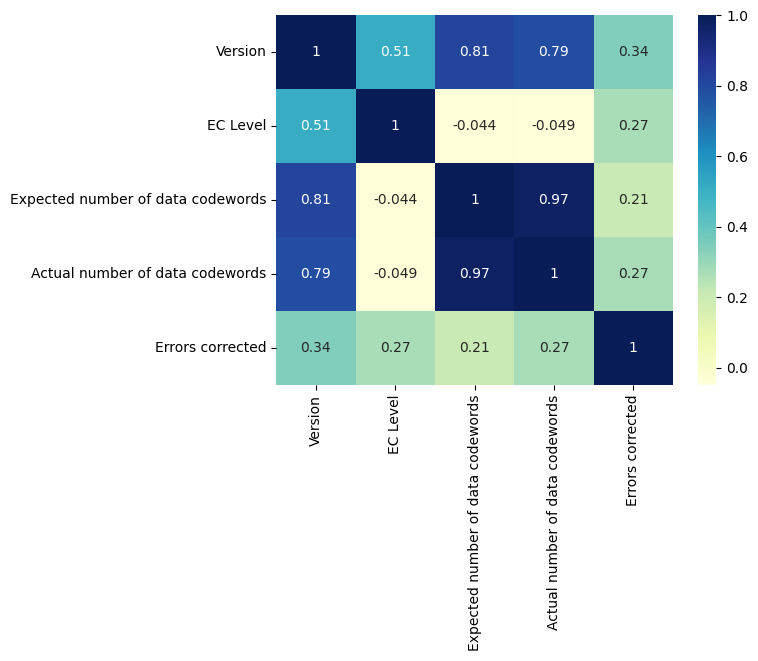

,Version,EC Level,Expected number of data codewords,Actual number of data codewords,Errors corrected
0,3,4,26,19,0
1,2,3,22,20,0
2,1,1,19,19,0
3,2,3,22,20,0
4,2,4,16,15,0
5,1,1,19,18,0
6,3,2,44,43,0
7,1,2,16,14,0
8,2,2,28,27,0
9,2,4,16,14,0


In [4]:
train_X = df[['Version', 'EC Level', 'Expected number of data codewords',
              'Actual number of data codewords',
              'Errors corrected']]

correlation_matrix = train_X.corr()

dataplot = sb.heatmap(correlation_matrix, cmap="YlGnBu", annot=True)
plt.show()
train_X.head(10)

In [5]:
train_y = df['Modified']
train_y.head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Modified, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_X,
                                                    train_y, test_size=0.2,
                                                    random_state=42)

X_train.head(10)

print("Test set size: " + str(X_test.size))
print("Train set size: " + str(X_train.size))

Test set size: 94455
Train set size: 377815


## Random Forest

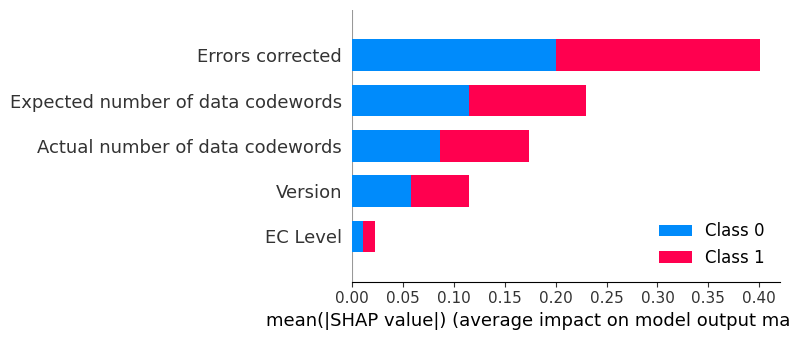

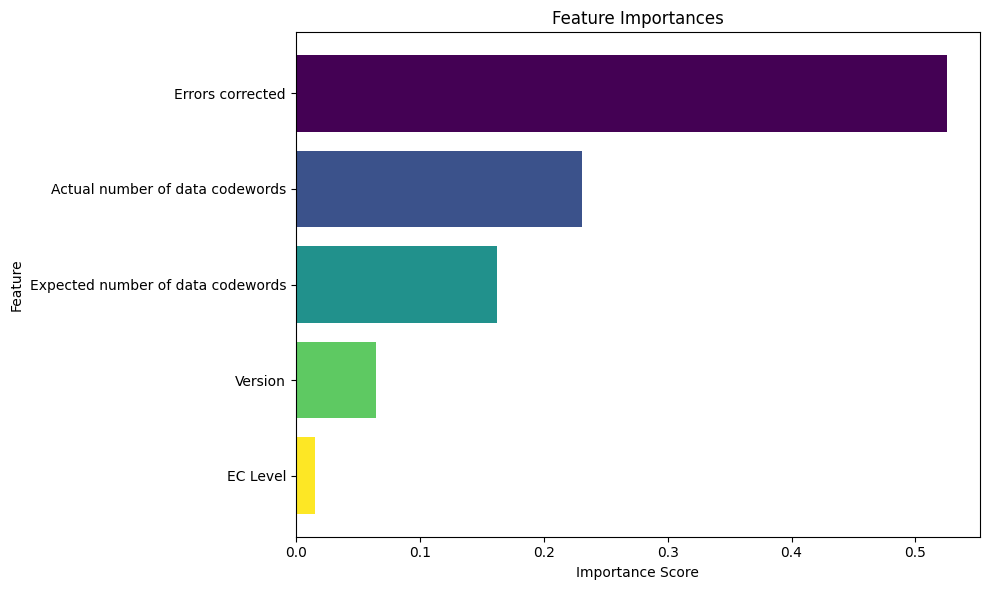

\begin{table}
\caption{Confusion Matrix}
\label{tab:confusion_matrix}
\begin{tabular}{lcc}
\toprule
 & 0 & 1 \\
\midrule
0 & 9664 & 260 \\
1 & 1294 & 7673 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Classification Report}
\label{tab:classification_report}
\begin{tabular}{lccc}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.882000 & 0.974000 & 0.926000 & 9924.000000 \\
1 & 0.967000 & 0.856000 & 0.908000 & 8967.000000 \\
accuracy & 0.918000 & 0.918000 & 0.918000 & 0.918000 \\
macro avg & 0.925000 & 0.915000 & 0.917000 & 18891.000000 \\
weighted avg & 0.922000 & 0.918000 & 0.917000 & 18891.000000 \\
\bottomrule
\end{tabular}
\end{table}



<Figure size 640x480 with 0 Axes>

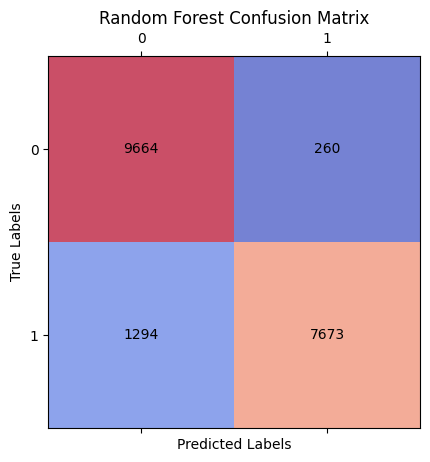

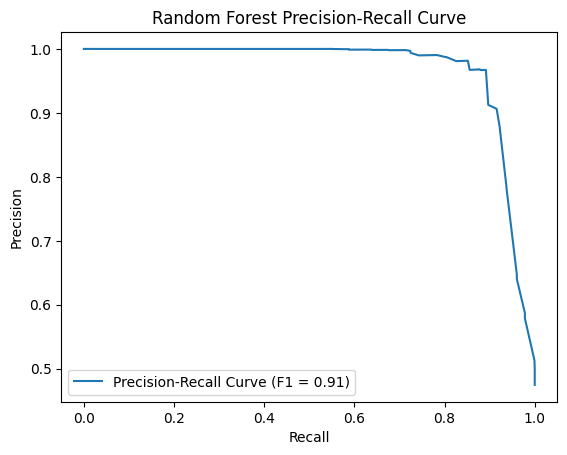

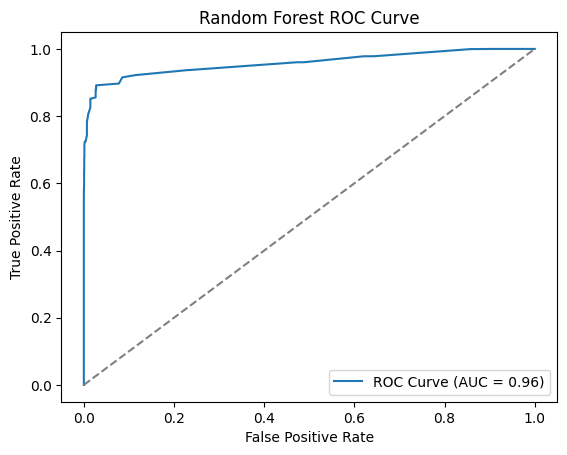

\begin{table}
\caption{ROC AUC for Random Forest}
\label{tab:roc_auc_random_forest}
\begin{tabular}{lc}
\toprule
Model & ROC AUC \\
\midrule
Random Forest & 0.958055 \\
\bottomrule
\end{tabular}
\end{table}

CPU times: user 7.02 s, sys: 1.2 s, total: 8.22 s
Wall time: 6.91 s


In [7]:
%%time
rf = RFC(random_state=42, criterion="entropy", n_estimators=50, max_depth=5)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

importances_full = rf.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances_full)[::-1]  # Sort in descending order
sorted_importances = importances_full[indices]
sorted_features = feature_names[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_importances))))

plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()

plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

class_labels = rf.classes_

cm = confusion_matrix(y_test, rf_pred)
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
latex_cm = df_cm.to_latex(
    caption="Confusion Matrix",
    label="tab:confusion_matrix",
    column_format="l" + "c" * len(class_labels)
)

report_dict = classification_report(y_test, rf_pred, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose().round(3)
latex_report = df_report.to_latex(
    caption="Classification Report",
    label="tab:classification_report",
    column_format="lccc"
)

print(latex_cm)
print(latex_report)

plot_confusion_matrix(y_test, rf_pred, title="Random Forest Confusion Matrix")
plot_precision_recall(y_test, rf_probs, model_name="Random Forest")
plot_roc_curve(y_test, rf_probs, model_name="Random Forest")
#print(classification_report(y_test, rf_pred))

crrf = classification_report(y_test, rf_pred, output_dict=True)
rfdf = pd.DataFrame(crrf).transpose()

## XGBoost

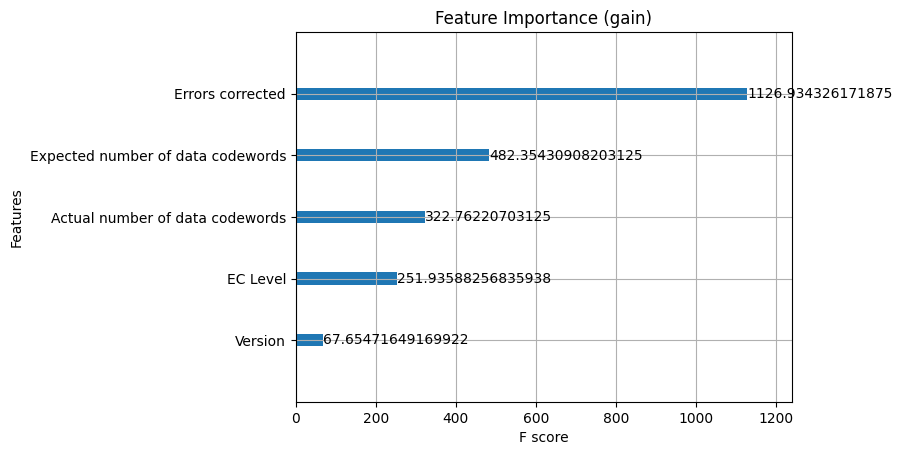

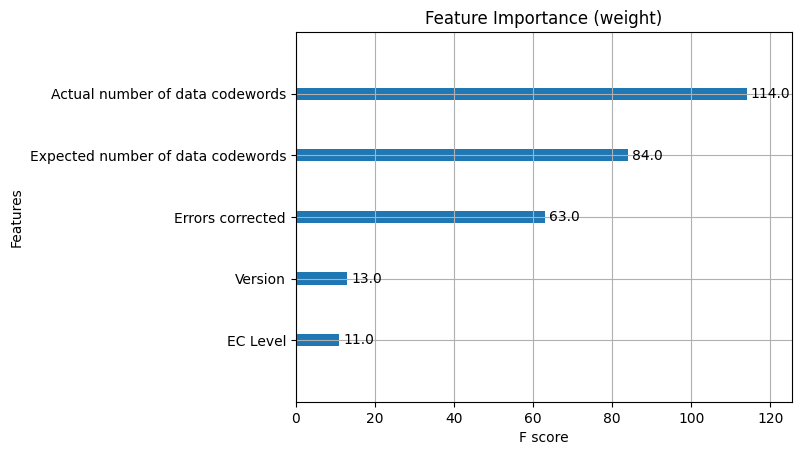

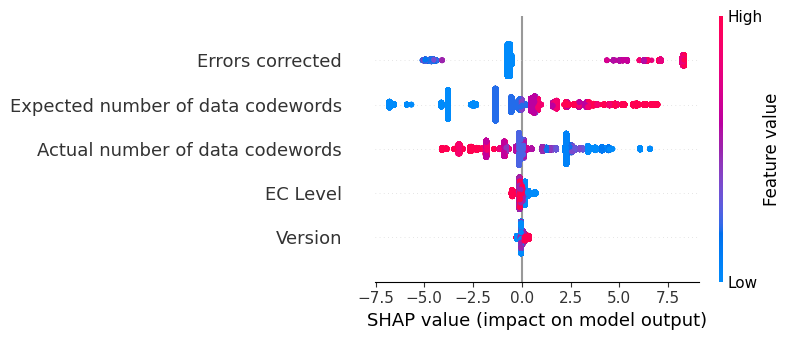

<Figure size 640x480 with 0 Axes>

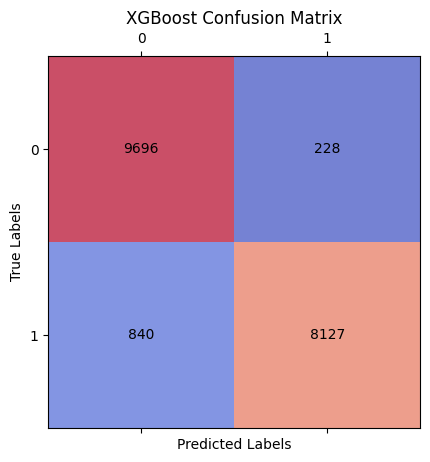

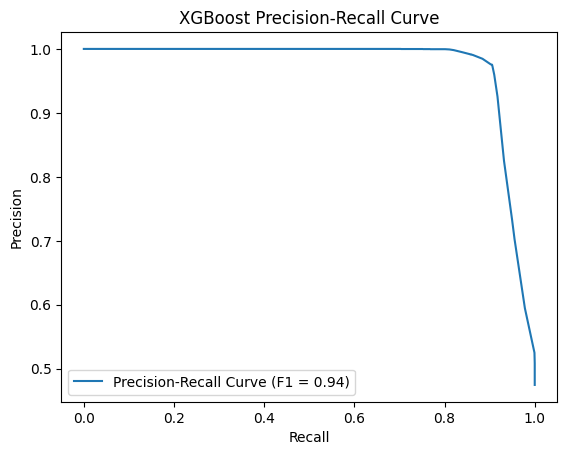

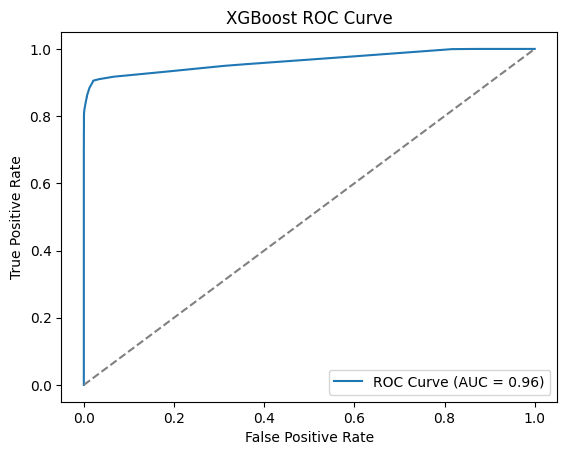

\begin{table}
\caption{ROC AUC for XGBoost}
\label{tab:roc_auc_xgboost}
\begin{tabular}{lc}
\toprule
Model & ROC AUC \\
\midrule
XGBoost & 0.964008 \\
\bottomrule
\end{tabular}
\end{table}

CPU times: user 10.3 s, sys: 2.37 s, total: 12.6 s
Wall time: 2.59 s


In [8]:
%%time
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_estimators=50, max_depth=3)
xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Plot the feature importance
plot_importance(xgb, importance_type='gain')
plt.title('Feature Importance (gain)')
plt.show()

plot_importance(xgb, importance_type='weight')
plt.title('Feature Importance (weight)')
plt.show()

# Calculate SHAP values
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

# Visualize SHAP values
shap.summary_plot(shap_values, X_train)

#feature_important = xgb.get_booster().get_score(importance_type='weight')
#keys = list(feature_important.keys())
#values = list(feature_important.values())

#data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
#data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

#feature_important1 = xgb.get_booster().get_score(importance_type='gain')
#print(feature_important1)
#keys1 = list(feature_important1.keys())
#values1 = list(feature_important1.values())

#data1 = pd.DataFrame(data=values1, index=keys1, columns=["score"]).sort_values(by = "score", ascending=False)
#data1.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

plot_confusion_matrix(y_test, xgb_pred, title="XGBoost Confusion Matrix")
plot_precision_recall(y_test, xgb_probs, model_name="XGBoost")
plot_roc_curve(y_test, xgb_probs, model_name="XGBoost")
#print(classification_report(y_test, xgb_pred))
crxgb = classification_report(y_test, xgb_pred, output_dict=True)
xgbdf = pd.DataFrame(crxgb).transpose()

## Support Vector Classifier

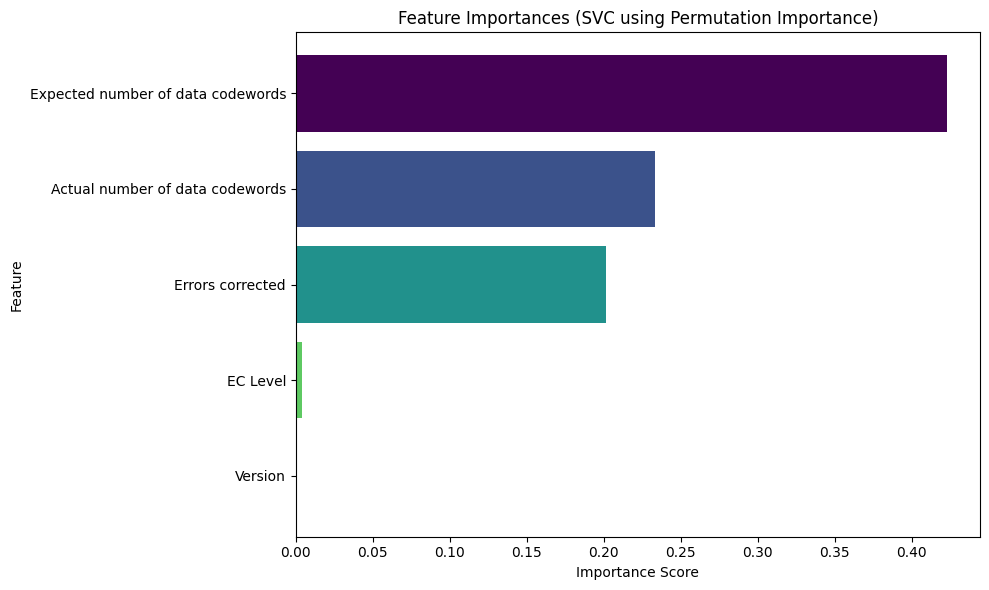

<Figure size 640x480 with 0 Axes>

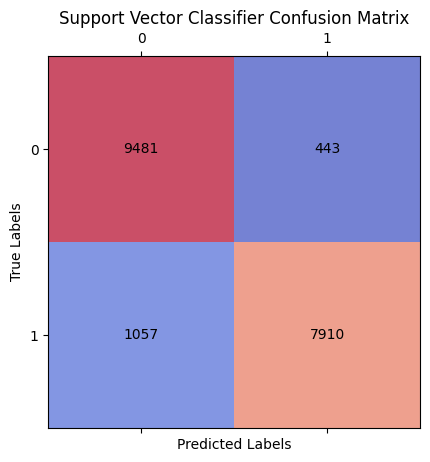

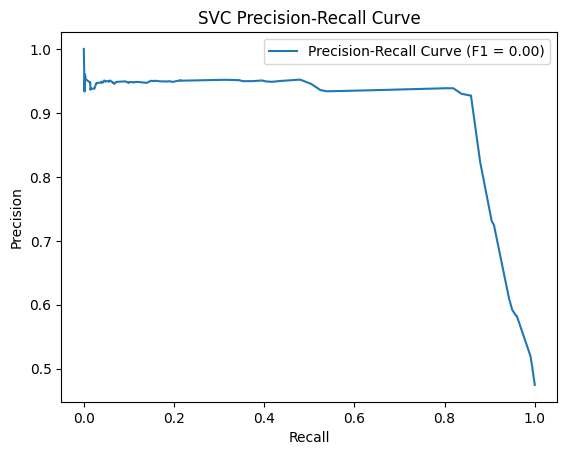

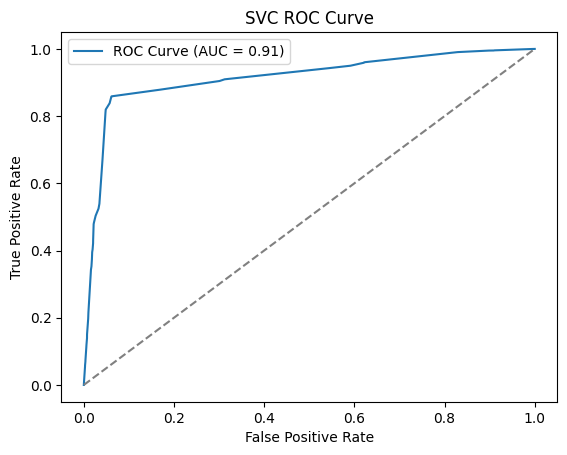

\begin{table}
\caption{ROC AUC for SVC}
\label{tab:roc_auc_svc}
\begin{tabular}{lc}
\toprule
Model & ROC AUC \\
\midrule
SVC & 0.914020 \\
\bottomrule
\end{tabular}
\end{table}

CPU times: user 29min 24s, sys: 8min 36s, total: 38min 1s
Wall time: 1min 2s


In [9]:
%%time
svc = SVC(probability=True, kernel='rbf', C=100, random_state=42)
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)
svc_probs = svc.predict_proba(X_test)[:, 1]

svc_imp = permutation_importance(svc, X_test, y_test, n_repeats=10, random_state=42)
svc_impts = svc_imp.importances_mean

feature_names = X_train.columns

indices = np.argsort(svc_impts)[::-1]
sorted_importances = svc_impts[indices]
sorted_features = feature_names[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_importances))))
plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()
plt.title("Feature Importances (SVC using Permutation Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plot_confusion_matrix(y_test, svc_pred, title="Support Vector Classifier Confusion Matrix")
plot_precision_recall(y_test, svc_probs, model_name="SVC")
plot_roc_curve(y_test, svc_probs, model_name="SVC")
#print(classification_report(y_test, svc_pred))
crsvc = classification_report(y_test, svc_pred, output_dict=True)
svcdf = pd.DataFrame(crsvc).transpose()

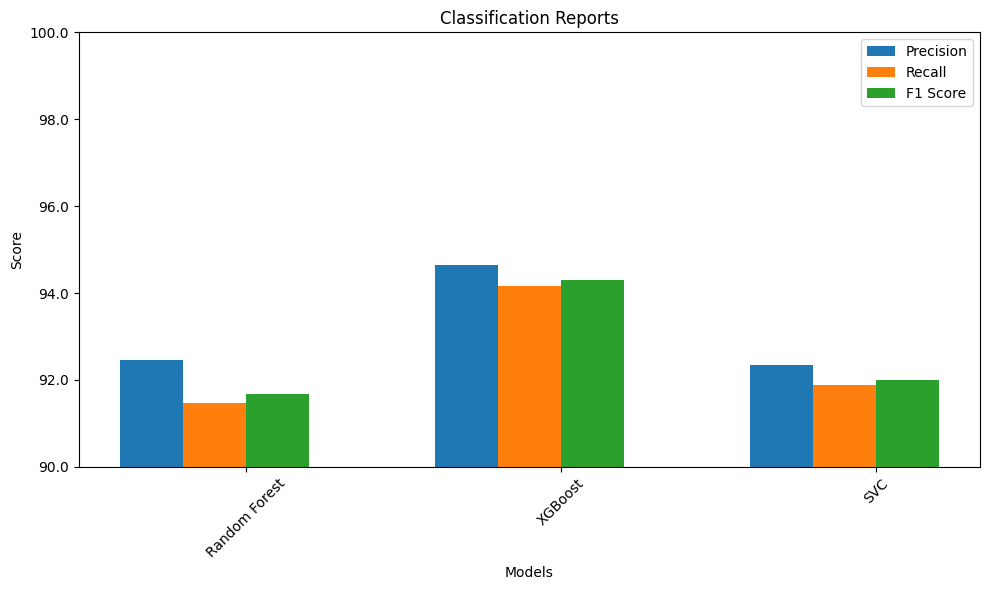

In [10]:
models = {
    "Random Forest": rfdf.loc["macro avg", ["precision", "recall", "f1-score"]],
    "XGBoost": xgbdf.loc["macro avg", ["precision", "recall", "f1-score"]],
    "SVC": svcdf.loc["macro avg", ["precision", "recall", "f1-score"]]
}
#roc_auc_scores = {
#    "Random Forest": roc_auc_score(y_test, rf_probs),
#    "XGBoost": roc_auc_score(y_test, xgb_probs),
#    "SVC": roc_auc_score(y_test, svc_probs)
#}
#print(crrf)
#print("xgb", crxgb)
#print("svc", crsvc)
#print(roc_auc_score(y_test, rf_probs))
#print(roc_auc_score(y_test, xgb_probs))
combined_df = pd.DataFrame(models).transpose() * 100
#combined_df["ROC AUC"] = [roc_auc_scores[model] * 100 for model in combined_df.index]
bar_width = 0.2
index = np.arange(len(combined_df))

plt.figure(figsize=(10, 6))

plt.bar(index, combined_df["precision"], bar_width, label="Precision")
plt.bar(index + bar_width, combined_df["recall"], bar_width, label="Recall")
plt.bar(index + 2 * bar_width, combined_df["f1-score"], bar_width, label="F1 Score")
#plt.bar(index + 3 * bar_width, combined_df["ROC AUC"], bar_width, label="ROC AUC")

plt.ylim(90, 100)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Classification Reports")
plt.xticks(index + 1.5 * bar_width, combined_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Dump model(s)

In [11]:
#rf.predict
dump(xgb, "model.xz")

['model.xz']